# LSTM

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from plotly.offline import iplot
from keras.layers import Dropout
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from mergen import StringAnalyzer, StringProfiling
%load_ext autotime

time: 0 ns (started: 2023-04-05 21:15:05 +03:00)


In [2]:
data = pd.read_csv("teknofest_train_final.csv", sep="|", encoding="utf-8")
data = data[['text','target']]
data = StringAnalyzer(data=data, columns='text').dataframe_analyze()
data.head()

,text,target
0,çürük dişli,INSULT
1,adamın islama müslümanlara verdiği zararı gavu...,RACIST
2,erkekler zora gelmez,SEXIST
3,utanmazın götüne kazık sokmuşlar tıkırtı geliy...,PROFANITY
4,otomasyon sistemlerine doğrudan bağlanabilir,OTHER


time: 1.31 s (started: 2023-04-05 21:15:05 +03:00)


In [3]:
MAX_NB_WORDS = 20000
MAX_SEQUENCE_LENGTH = 25
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(data['text'].values)
word_index = tokenizer.word_index
print(len(word_index))

23981
time: 234 ms (started: 2023-04-05 21:15:07 +03:00)


In [4]:
X = tokenizer.texts_to_sequences(data['text'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print(X.shape)

(12617, 25)
time: 203 ms (started: 2023-04-05 21:15:07 +03:00)


In [5]:
Y = pd.get_dummies(data['target']).values
print(Y.shape)

(12617, 5)
time: 16 ms (started: 2023-04-05 21:15:07 +03:00)


In [6]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(11355, 25) (11355, 5)
(1262, 25) (1262, 5)
time: 0 ns (started: 2023-04-05 21:15:07 +03:00)


In [7]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 25, 100)           2000000   
                                                                 
 spatial_dropout1d (SpatialD  (None, 25, 100)          0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 5)                 505       
                                                                 
Total params: 2,080,905
Trainable params: 2,080,905
Non-trainable params: 0
_________________________________________________________________
None
time: 328 ms (started: 2023-04-05 21:15:07 +03:00)


In [8]:
epochs = 5
batch_size = 32

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/5
320/320 [==============================] - 36s 102ms/step - loss: 1.1623 - accuracy: 0.5266 - val_loss: 0.7300 - val_accuracy: 0.7412
Epoch 2/5
320/320 [==============================] - 29s 91ms/step - loss: 0.3905 - accuracy: 0.8709 - val_loss: 0.5604 - val_accuracy: 0.7958
Epoch 3/5
320/320 [==============================] - 29s 90ms/step - loss: 0.1497 - accuracy: 0.9527 - val_loss: 0.6357 - val_accuracy: 0.7940
Epoch 4/5
320/320 [==============================] - 29s 90ms/step - loss: 0.0862 - accuracy: 0.9699 - val_loss: 0.6369 - val_accuracy: 0.7887
Epoch 5/5
320/320 [==============================] - 29s 90ms/step - loss: 0.0668 - accuracy: 0.9767 - val_loss: 0.7469 - val_accuracy: 0.7861
time: 2min 31s (started: 2023-04-05 21:15:08 +03:00)


In [9]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

40/40 [==============================] - 1s 14ms/step - loss: 0.7927 - accuracy: 0.7876
Test set
  Loss: 0.793
  Accuracy: 0.788
time: 656 ms (started: 2023-04-05 21:17:39 +03:00)


In [11]:
from sklearn.metrics import f1_score

# Eğitim verilerinin tahmini
y_pred_train = model.predict(X_train)
y_pred_train = np.argmax(y_pred_train, axis=1)

# F1 skoru hesaplama
f1_train = f1_score(np.argmax(Y_train, axis=1), y_pred_train, average='weighted')

# Test verilerinin tahmini
y_pred_test = model.predict(X_test)
y_pred_test = np.argmax(y_pred_test, axis=1)

# F1 skoru hesaplama
f1_test = f1_score(np.argmax(Y_test, axis=1), y_pred_test, average='weighted')

print("Train F1 score: ", f1_train)
print("Test F1 score: ", f1_test)

40/40 [==============================] - 0s 9ms/step
Train F1 score:  0.9628523307504523
Test F1 score:  0.7921330050595278
time: 3.55 s (started: 2023-04-05 21:18:35 +03:00)


40/40 [==============================] - 0s 9ms/step


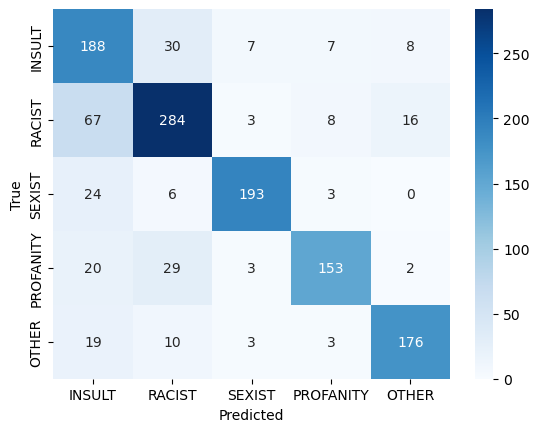

time: 735 ms (started: 2023-04-05 21:18:41 +03:00)


In [12]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
# kategori isimleri
categories = data['target'].unique().tolist()
# modelin tahminleri
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
# gerçek sınıflar
y_true = np.argmax(Y_test, axis=1)
# confusion matrix
cm = confusion_matrix(y_true, y_pred)
# confusion matrix grafiği
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

40/40 [==============================] - 0s 9ms/step


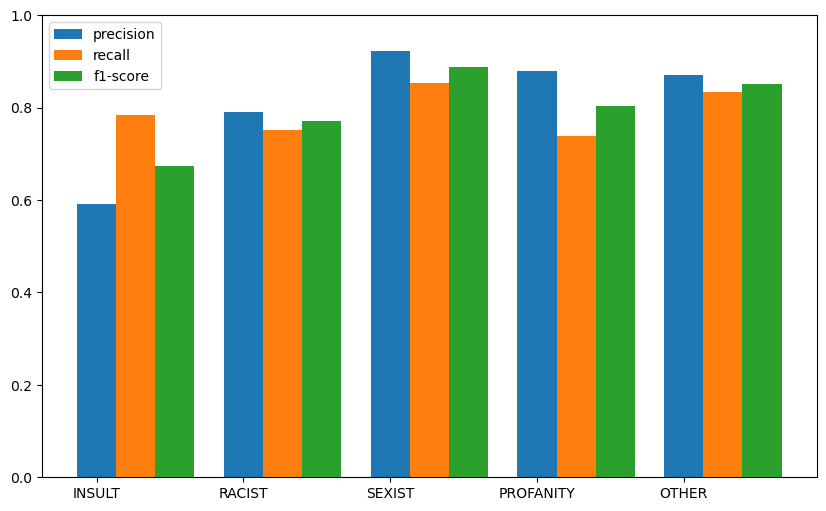

time: 593 ms (started: 2023-04-05 21:18:44 +03:00)


In [13]:
from sklearn.metrics import classification_report

# Sınıflandırma etiketlerini tahmin et
Y_pred = model.predict(X_test)

# En yüksek olasılığa sahip sınıf etiketlerini seç
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(Y_test, axis=1)

# Sınıf bazında doğruluk, hassasiyet ve F1 skorlarını hesapla
report = classification_report(Y_true, Y_pred_classes, target_names=['INSULT', 'RACIST', 'SEXIST', 'PROFANITY', 'OTHER'], output_dict=True)

# Bar grafiği oluştur
fig, ax = plt.subplots(figsize=(10, 6))
class_names = list(report.keys())[:-3] # Son üç satır hassasiyet, doğruluk ve F1 Skoru toplamları olduğundan bunları çıkardık
metrics = ['precision', 'recall', 'f1-score']
for i, metric in enumerate(metrics):
    ax.bar([j+(i*0.8/3) for j in range(1, len(class_names)+1)], [report[class_name][metric] for class_name in class_names], width=0.8/3, label=metric)
ax.set_xticks(range(1, len(class_names)+1))
ax.set_xticklabels(class_names)
ax.set_ylim([0, 1])
ax.legend()
plt.show()

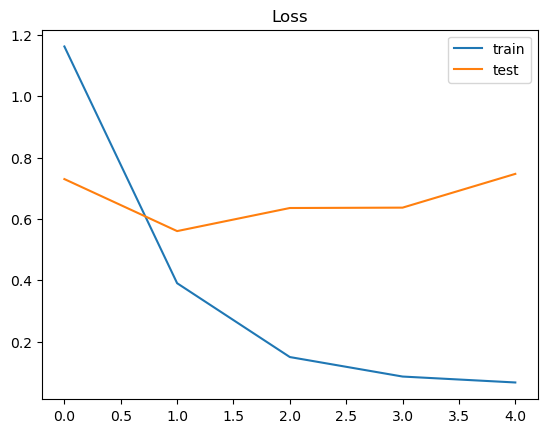

time: 156 ms (started: 2023-04-05 21:18:45 +03:00)


In [14]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

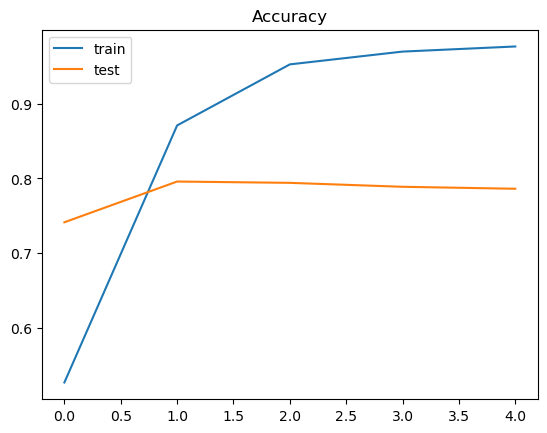

time: 125 ms (started: 2023-04-05 21:18:46 +03:00)


In [15]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

In [ ]:
#model.save("tf_model.h5")